In [1]:
import pandas as pd

訓練データを読み込み

In [3]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


欠損値を確認する

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabinは量が多すぎるため削除し、AgeとEmbarkedを補完する

使用しない変数を削除

In [7]:
df.index = df["PassengerId"]
df = df.drop([
            'PassengerId',
            'Name',
            'Cabin',
            'Ticket'
            ],
            axis=1)

In [9]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [11]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Embarkedは少ない欠損であり質的変数であるため最頻値で補完するためにヒストグラムをプロットする。

PassengerId
1      S
2      C
3      S
4      S
5      S
      ..
887    S
888    S
889    S
890    C
891    Q
Name: Embarked, Length: 891, dtype: object

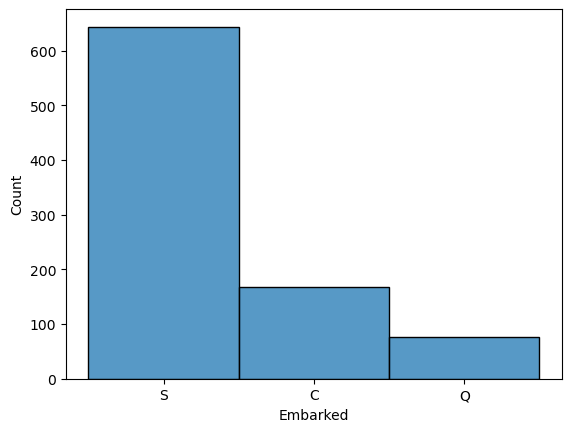

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df["Embarked"])
df["Embarked"].fillna("S")

Ageの補完をするためにSexとEmbarkedをダミー変数にする。

In [15]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,False,True,False,False,True
2,1,1,38.0,1,0,71.2833,True,False,True,False,False
3,1,3,26.0,0,0,7.9250,True,False,False,False,True
4,1,1,35.0,1,0,53.1000,True,False,False,False,True
5,0,3,35.0,0,0,8.0500,False,True,False,False,True


データ数が多いため機械学習を用いた補完をする。ここで、GBDTは変数の前処理(標準化など)をする必要がないためGBDTを用いて欠損値を予測して補完する。

訓練データは欠損がない部分で、テストデータは欠損がある部分にする。

In [17]:
train = df.copy()
train_train = train.dropna()
train_test = train[train["Age"].isnull()]

In [19]:
from lightgbm import LGBMRegressor

In [21]:
x_train = train_train.drop("Age", axis=1)
x_test = train_test.drop("Age", axis=1)
y_train = train_train["Age"]
model = LGBMRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 10
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

予測結果を埋めるためインデックスを揃える。

In [23]:
pred = pd.DataFrame(y_pred)
pred.index = train_test.index
pred.columns = ["Age"]
train_test["Age"] = pred["Age"]
train_test.isnull().sum()

C:\Users\decar\AppData\Local\Temp\ipykernel_6620\331734401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test["Age"] = pred["Age"]


Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

欠損値がなくなったことが確認できた。

ここで訓練データを元の形に戻す。そこで先ほどのインデックスが役に立つ。

In [25]:
train = pd.concat([train_test, train_train])
train.sort_index().head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,False,True,False,False,True
2,1,1,38.000000,1,0,71.2833,True,False,True,False,False
3,1,3,26.000000,0,0,7.9250,True,False,False,False,True
4,1,1,35.000000,1,0,53.1000,True,False,False,False,True
5,0,3,35.000000,0,0,8.0500,False,True,False,False,True
6,0,3,33.175847,0,0,8.4583,False,True,False,True,False
7,0,1,54.000000,0,0,51.8625,False,True,False,False,True
8,0,3,2.000000,3,1,21.0750,False,True,False,False,True
9,1,3,27.000000,0,2,11.1333,True,False,False,False,True


テストデータの欠損を確認する。

In [27]:
test = pd.read_csv("test.csv")
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Cabinはここでも多いため削除する。FareとAgeを補完する。

In [37]:
test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,34.5,0,0,7.8292,True,False,True,False
893,3,47.0,1,0,7.0000,False,False,False,True
894,2,62.0,0,0,9.6875,True,False,True,False
895,3,27.0,0,0,8.6625,True,False,False,True
896,3,22.0,1,1,12.2875,False,False,False,True
...,...,...,...,...,...,...,...,...,...
1305,3,NaN,0,0,8.0500,True,False,False,True
1306,1,39.0,0,0,108.9000,False,True,False,False
1307,3,38.5,0,0,7.2500,True,False,False,True


Fareは量的データであるためヒストグラムを出力するだけでなくヒストグラムの具体的な値を出力する。

(array([  3., 152.,  68.,  16.,  26.,  44.,  11.,   9.,   4.,   5.,   9.,
         10.,   5.,   5.,   6.,   5.,   5.,   1.,   2.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   6.,   0.,   1.,   2.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   3.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   7.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  0.      ,   5.123292,  10.246584,  15.369876,  20.493168,
         25.61646 ,  30.739752,  35.863044,  40.986336,  46.109628,
         51.23292 ,  56.356212,  61.479504,  66.602796,  71.726088,
         76.84938 ,  81.972672,  87.095964,  92.219256,  97.342548,
        102.46584 , 107.589132, 112.712424, 11

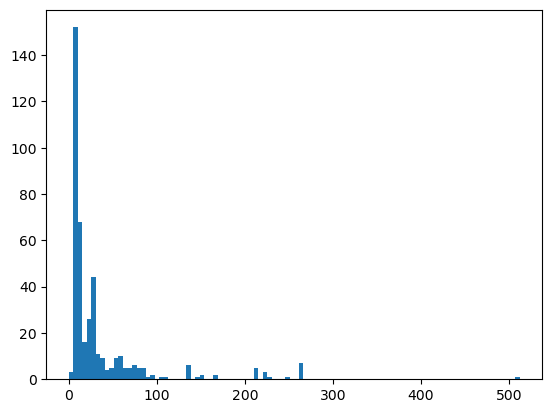

In [29]:
plt.hist(test["Fare"], bins=100)

5.123292が152と最も多かったためこれで補完する。

In [31]:
test["Fare"] = test["Fare"].fillna(5.123292)
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

欠損値が補完されたことを確認できた。

使用しない変数を削除する。

In [33]:
test.index = test["PassengerId"]
test = test.drop([
            'PassengerId',
            'Name',
            'Cabin',
            'Ticket'
            ],
            axis=1)
test = pd.get_dummies(test)
test = test.drop("Sex_female", axis=1)

Ageを補完するため質的変数をダミー変数にする。

In [35]:
test = pd.get_dummies(test)
test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,34.5,0,0,7.8292,True,False,True,False
893,3,47.0,1,0,7.0000,False,False,False,True
894,2,62.0,0,0,9.6875,True,False,True,False
895,3,27.0,0,0,8.6625,True,False,False,True
896,3,22.0,1,1,12.2875,False,False,False,True
...,...,...,...,...,...,...,...,...,...
1305,3,NaN,0,0,8.0500,True,False,False,True
1306,1,39.0,0,0,108.9000,False,True,False,False
1307,3,38.5,0,0,7.2500,True,False,False,True


Ageの欠損の数を確認する。

In [39]:
test_test = test[test["Age"].isnull()]
print(len(test_test))
test_test.isnull().sum()

86


Pclass         0
Age           86
SibSp          0
Parch          0
Fare           0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

欠損を機械学習で補完するため訓練データとテストデータに分ける。

In [41]:
test_train = test.dropna()
test_train.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

年齢をGBDTで予測する。

In [43]:
x_train = test_train.drop("Age", axis=1)
x_test = test_test.drop("Age", axis=1)
y_train = test_train["Age"]
model = LGBMRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 8
[LightGBM] [Info] Start training from score 30.272590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

訓練データとテストデータを結合する。

In [45]:
df_test = pd.concat([test_train, test_test])

Ageの補完後のインデックスを揃える。

In [47]:
age = pd.DataFrame(y_pred)
print(len(age), len(x_test))
age.index = test_test.index
age.columns = ["Age"]
test_test["Age"] = age["Age"]
test_test.isnull().sum()

86 86


C:\Users\decar\AppData\Local\Temp\ipykernel_6620\2180239995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_test["Age"] = age["Age"]


Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

欠損がなくなったことが確認できた。

In [49]:
test_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
902,3,27.347733,0,0,7.8958,True,False,False,True
914,1,40.627558,0,0,31.6833,False,False,False,True
921,3,26.179765,2,0,21.6792,True,True,False,False
925,3,20.599990,1,2,23.4500,False,False,False,True
928,3,22.185951,0,0,8.0500,False,False,False,True
...,...,...,...,...,...,...,...,...,...
1300,3,26.381925,0,0,7.7208,False,False,True,False
1302,3,26.478421,0,0,7.7500,False,False,True,False
1305,3,25.297441,0,0,8.0500,True,False,False,True


In [53]:
df_test = pd.concat([test_train, test_test])
df_test.isnull().sum()
df_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,34.500000,0,0,7.8292,True,False,True,False
893,3,47.000000,1,0,7.0000,False,False,False,True
894,2,62.000000,0,0,9.6875,True,False,True,False
895,3,27.000000,0,0,8.6625,True,False,False,True
896,3,22.000000,1,1,12.2875,False,False,False,True
...,...,...,...,...,...,...,...,...,...
1300,3,26.381925,0,0,7.7208,False,False,True,False
1302,3,26.478421,0,0,7.7500,False,False,True,False
1305,3,25.297441,0,0,8.0500,True,False,False,True


欠損値が補完できたためSurvivedを予測する。

まず訓練データを準備する。

In [55]:
df_train = train.copy()
df_train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
6,0,3,33.175847,0,0,8.4583,False,True,False,True,False
18,1,2,31.300905,0,0,13.0000,False,True,False,False,True
20,1,3,15.633606,0,0,7.2250,True,False,True,False,False
27,0,3,31.146361,0,0,7.2250,False,True,True,False,False
29,1,3,19.519718,0,0,7.8792,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,39.000000,0,5,29.1250,True,False,False,True,False
887,0,2,27.000000,0,0,13.0000,False,True,False,False,True
888,1,1,19.000000,0,0,30.0000,True,False,False,False,True


多重共線性を考慮してダミー変数を一つずつ削除し、説明変数は目的変数を削除する。

modelsのリストを作成してモデルと評価値(正解率)を格納する。その後、正解率を元に降順にリストを並び替える。

In [57]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
models = []
x = df_train.drop(["Survived", "Sex_female", "Embarked_C"], axis=1)
y = df_train["Survived"]
for i in range(200):
    x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=i, test_size=0.3)
    model = LGBMClassifier()
    model.fit(x_train, y_train)
    models.append([model, model.score(x_val, y_val)])
models = sorted(models, key=lambda x:x[1], reverse=True)

[LightGBM] [Info] Number of positive: 242, number of negative: 381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388443 -> initscore=-0.453862
[LightGBM] [Info] Start training from score -0.453862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


上位3つのモデルを使って予測する。この時最頻値を使う。

In [59]:
df_test = df_test.drop(["Embarked_C"], axis=1)
from scipy.stats import mode
model1 = models[0][0]
model2 = models[1][0]
model3 = models[2][0]
y_pred1 = model1.predict(df_test)
y_pred2 = model2.predict(df_test)
y_pred3 = model3.predict(df_test)
y_pred = []
for i in range(len(y_pred1)):
    y_pred.append(mode([y_pred1[i],y_pred2[i],y_pred3[i]])[0])
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,


予測結果をデータフレーム化する

In [61]:
df_pred = pd.DataFrame(y_pred)
df_pred.columns = ["Survived"]
df_pred.index = df_test.index
df_pred

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1300,0
1302,1
1305,0


提出するファイルを作成する。

In [63]:
df_pred.sort_index().to_csv("submission10.csv")